In [50]:
import time
from io import StringIO
import urllib.request as urlreq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [51]:
# -----------------------------------------------------------------------------
# Part I: Data Loading, EDA, and Preprocessing
# -----------------------------------------------------------------------------

def load_and_prepare(threshold: int = 6):
    """Load the dataset, prepare it and transform for binary classification"""
    base = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
    red   = pd.read_csv(StringIO(urlreq.urlopen(base + "winequality-red.csv").read().decode()), sep=";")
    white = pd.read_csv(StringIO(urlreq.urlopen(base + "winequality-white.csv").read().decode()), sep=";")
    red["type"], white["type"] = "red", "white"
    df = pd.concat([red, white], ignore_index=True)

    # Binary target: quality > threshold → 1 (good), otherwise 0 (bad)
    df["target"] = (df["quality"] > threshold).astype(int)

    features = [c for c in df.columns if c not in ("quality", "type", "target")]
    X, y = df[features].values, df["target"].values

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.3,
        random_state=RANDOM_STATE,
        stratify=y
    )

    scaler = StandardScaler().fit(X_tr)
    return scaler.transform(X_tr), scaler.transform(X_te), y_tr, y_te, df, features

def quick_eda(df: pd.DataFrame):
    """Basic statistics and visualizations about the dataset"""
    y = df["target"].values
    print("Part I : Dataset Exploration")
    print("-" * 50)
    print(f"Shape              : {df.shape}")
    unique, counts = np.unique(y, return_counts=True)
    print(f"Class distribution : {dict(zip(unique, counts))}")
    print(f"Positive rate      : {y.mean():.2%}")

    # 1. Scatter matrix for top correlated features
    feat_df = df.drop(columns=["quality", "type", "target"])
    corr = feat_df.corrwith(df["target"]).abs().sort_values(ascending=False)
    top4 = corr.index[:4].tolist()
    plt.figure(figsize=(10, 8))
    scatter_matrix(
        df[top4],
        figsize=(10, 8),
        diagonal='kde',
        c=y,
        marker='o',
        alpha=0.5
    )
    plt.suptitle("Top 4 features most correlated with target", y=1.02)
    plt.tight_layout()
    plt.show()

    # 2. Class distribution visualization
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x="target", data=df, palette="Set2")
    plt.title("Class Distribution")
    plt.xlabel("Wine Quality (0=Bad, 1=Good)")
    plt.ylabel("Count")

    # Add count labels on top of bars
    for i, count in enumerate(counts):
        ax.text(i, count + 50, f"{count} ({count/sum(counts):.1%})",
               ha='center', va='bottom', fontweight='bold')

    # Add imbalance ratio annotation
    imbalance_ratio = counts[0] / counts[1]
    plt.figtext(0.5, -0.05,
                f"Class Imbalance Ratio (Bad:Good) = {imbalance_ratio:.1f}:1",
                ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

# *Data Loading, EDA, and Preprocessing*

<br>

## **load_and_prepare**

In this section, both red and white wine datasets were retrieved from the UCI Machine Learning Repository and merged into a single dataset using pandas. Each dataset was labeled with a "type" column to indicate the wine type and concatenated into a unified DataFrame. A binary classification problem was then created by converting the "quality" column into a binary target label: wines with a quality score above a given threshold (default: 6) were labeled as “good” (1), and the rest as “bad” (0).

This transformation simplifies the learning task and enables clearer interpretation of model results. The features used for training excluded "quality", "type", and the newly created "target". The dataset was split into training and test sets using train_test_split with stratification to maintain the original class distribution. Standardization was applied using StandardScaler, which is essential for models like MLP that are sensitive to feature scaling. Without normalization, features with different ranges could dominate the gradient calculations, leading to poor convergence behavior.

<br>
<br>

## **quick_eda**

The quick_eda function provides a concise but informative overview of the dataset through basic statistics and visualizations. It starts by displaying the dataset shape, class distribution, and the percentage of “good quality” wine samples. Then, the top 4 features most correlated with the target variable are selected, and a scatter matrix is plotted to explore their relationships visually. This helps in identifying strong predictors for the classification task.

Additionally, a bar plot is used to visualize the class distribution, highlighting the imbalance between the “bad” and “good” classes. Percentage labels are annotated above the bars, and the imbalance ratio (e.g., 3.1:1) is indicated at the bottom. Such an imbalance can significantly affect model performance, making it necessary to consider techniques like weighted loss functions or resampling to mitigate its impact.

In [52]:
# -----------------------------------------------------------------------------
# Utility: Enhanced Model Evaluation
# -----------------------------------------------------------------------------

def find_optimal_threshold(y_true, y_score):
    """Find the threshold that maximizes F1 score"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)
    # Calculate F1 for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    # Find the optimal threshold
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5, f1_scores[optimal_idx]

def evaluate_model(clf, X_tr, X_te, y_tr, y_te, name: str, labels=("Bad", "Good")):
    """Enhanced model evaluation with optimal threshold and curve visualization"""
    t0 = time.time()
    clf.fit(X_tr, y_tr)
    tr_time = time.time() - t0

    # Get predictions and probabilities
    if hasattr(clf, "predict_proba"):
        probas = clf.predict_proba(X_te)[:, 1]
        # Find optimal threshold for F1
        opt_threshold, best_f1 = find_optimal_threshold(y_te, probas)
        # Apply optimal threshold
        y_pr = (probas >= opt_threshold).astype(int)
    else:
        probas = None
        y_pr = clf.predict(X_te)
        opt_threshold = 0.5
        best_f1 = f1_score(y_te, y_pr)

    print(f"\n{name}")
    print("-" * 50)
    print(f"Accuracy  : {accuracy_score(y_te, y_pr):.4f}")
    print(f"Precision : {precision_score(y_te, y_pr, zero_division=0):.4f}")
    print(f"Recall    : {recall_score(y_te, y_pr):.4f}")
    print(f"F1 score  : {f1_score(y_te, y_pr):.4f}")
    if probas is not None:
        print(f"AUC       : {roc_auc_score(y_te, probas):.4f}")
        print(f"Optimal threshold : {opt_threshold:.4f}")
    print(f"Train time: {tr_time:.4f}s")
    print("\n" + classification_report(y_te, y_pr, target_names=labels, digits=4))

    # Plot confusion matrix
    cm = confusion_matrix(y_te, y_pr)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} – Confusion Matrix (Threshold: {opt_threshold:.3f})")

    # Add summary statistics
    tp, fn = cm[1][1], cm[1][0]
    fp, tn = cm[0][1], cm[0][0]
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    plt.figtext(0.5, -0.05,
                f"Training time: {tr_time:.2f}s | Accuracy: {accuracy:.4f} | F1 Score: {best_f1:.4f}",
                ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

    # Plot ROC Curve if we have probabilities
    if probas is not None:
        # 1. ROC Curve
        plt.figure(figsize=(8, 6))
        roc_display = RocCurveDisplay.from_predictions(
            y_te,
            probas,
            name=name,
            plot_chance_level=True
        )
        plt.grid(alpha=0.3)
        plt.title(f"{name} - ROC Curve (AUC = {roc_auc_score(y_te, probas):.4f})")
        plt.tight_layout()
        plt.show()

        # 2. Precision-Recall Curve with optimal threshold
        plt.figure(figsize=(8, 6))
        pr_display = PrecisionRecallDisplay.from_predictions(
            y_te,
            probas,
            name=name
        )
        plt.axhline(y=y_te.mean(), color='gray', linestyle='--',
                   label=f'Baseline (Positive rate = {y_te.mean():.3f})')

        # Highlight optimal threshold point
        precisions, recalls, thresholds = precision_recall_curve(y_te, probas)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        if optimal_idx < len(thresholds):
            opt_precision = precisions[optimal_idx]
            opt_recall = recalls[optimal_idx]
            plt.plot(opt_recall, opt_precision, 'ro', markersize=8,
                    label=f'Optimal Threshold: {opt_threshold:.3f}')

        plt.grid(alpha=0.3)
        plt.legend()
        plt.title(f"{name} - Precision-Recall Curve")
        plt.tight_layout()
        plt.show()

    return {
        "Accuracy": accuracy_score(y_te, y_pr),
        "Precision": precision_score(y_te, y_pr, zero_division=0),
        "Recall": recall_score(y_te, y_pr),
        "F1": f1_score(y_te, y_pr),
        "AUC": roc_auc_score(y_te, probas) if probas is not None else None,
        "Optimal Threshold": opt_threshold,
        "Training Time": tr_time
    }

# Utility - Model Evaluation and Threshold Optimization

<br>

## **find_optimal_threshold**

This utility function computes the optimal threshold that maximizes the F1 score based on model output probabilities. Using precision_recall_curve, it calculates precision and recall values across different thresholds. Then, F1 scores are computed for each threshold, and the one yielding the highest F1 score is selected. This approach is particularly beneficial for imbalanced datasets, where the standard threshold of 0.5 might not yield the best performance due to uneven class distribution. Optimizing the threshold ensures that the balance between precision and recall is tuned to the dataset’s characteristics.

<br>
<br>

## **evaluate_model**

The evaluate_model function provides a thorough performance analysis of any classifier. It begins by fitting the model and measuring training time. If the model supports probability predictions (via predict_proba), it finds the optimal threshold using find_optimal_threshold and applies it to convert probabilities into binary predictions. Otherwise, it directly uses the model’s predict method.

The function then reports standard classification metrics:

  * Accuracy, Precision, Recall, F1 Score, and AUC (if available).
  * It also prints the classification report for class-wise breakdown.
  * A confusion matrix is plotted for detailed inspection of true/false predictions.
  * If available, ROC Curve and Precision-Recall Curve are plotted, including an annotated optimal threshold point.

These visualizations not only communicate the model’s overall performance but also provide insight into its strengths and weaknesses in classification boundaries, class imbalance handling, and threshold sensitivity. The function concludes by returning all key metrics in a dictionary, making it easier to compare multiple models later.

In [53]:
# -----------------------------------------------------------------------------
# Part II: Optimized MLP & AdaBoost
# -----------------------------------------------------------------------------

class MLPForAdaBoost(BaseEstimator, ClassifierMixin):
    """Custom MLP classifier for AdaBoost"""
    def __init__(self, **kw):
        self.kw = kw

    def fit(self, X, y, sample_weight=None):
        self.mlp_ = MLPClassifier(**self.kw)
        if sample_weight is None:
            self.mlp_.fit(X, y)
        else:
            p = sample_weight / sample_weight.sum()
            idx = np.random.choice(len(X), size=len(X), replace=True, p=p)
            self.mlp_.fit(X[idx], y[idx])
        self.classes_ = self.mlp_.classes_
        return self

    def predict(self, X):
        return self.mlp_.predict(X)

    def predict_proba(self, X):
        return self.mlp_.predict_proba(X)

# MLPForAdaBoost

This class defines a custom wrapper around the MLPClassifier to enable its use as a base learner in AdaBoost. It inherits from BaseEstimator and ClassifierMixin, which are necessary for compatibility with scikit-learn's ensemble methods. The class is designed to behave like a typical classifier but incorporates logic for weighted resampling, which is central to the AdaBoost algorithm.

In the fit method, the model either fits directly to the input data or performs weighted bootstrap resampling if sample_weight is provided. This resampling is performed using np.random.choice, with probabilities proportional to the sample weights. Such an approach mimics AdaBoost's mechanism of focusing more on previously misclassified samples by increasing their weights in subsequent iterations.

The predict and predict_proba methods simply delegate prediction to the underlying MLPClassifier. By encapsulating the MLP in this way, the class allows neural networks to serve as flexible weak learners within the AdaBoost framework—something not directly supported in standard scikit-learn.

This component plays a pivotal role in extending AdaBoost's capabilities beyond decision trees, demonstrating how ensemble methods can be combined with more powerful nonlinear learners like neural networks.

In [54]:
# -----------------------------------------------------------------------------
# Part III: Optimized Perceptron Forest
# -----------------------------------------------------------------------------

class PerceptronNode:
    """Perceptron-based decision tree node"""
    def __init__(self, depth=0, max_depth=7, feat_frac=0.9, rng=None, class_weight=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feat_frac = feat_frac
        self.rng = np.random.default_rng(rng)
        self.class_weight = class_weight
        self.leaf = False
        self.perceptron = None
        self.selected_features = None
        self.threshold = 0.5  # Default threshold value

    def fit(self, X, y):
        n, m = X.shape

        # Leaf node checks
        if n < 5 or self.depth >= self.max_depth or len(np.unique(y)) < 2:
            self.leaf = True
            # Adjust leaf prediction threshold for imbalanced data
            pos_ratio = np.mean(y)
            # If positive samples are few, lower the threshold
            self.threshold = max(0.3, min(pos_ratio, 0.7))
            self.pred = int(pos_ratio >= self.threshold)
            return self

        # Select random feature subset
        k = max(2, int(self.feat_frac * m))
        self.selected_features = self.rng.choice(m, k, replace=False)
        X_subset = X[:, self.selected_features]

        # Train an improved Perceptron classifier
        # SGDClassifier provides a more robust perceptron implementation
        self.perceptron = SGDClassifier(
            loss="perceptron",
            max_iter=200,
            tol=1e-4,
            alpha=0.01,
            learning_rate="adaptive",
            eta0=0.1,
            class_weight=self.class_weight,
            random_state=self.rng.integers(1e9)
        )

        self.perceptron.fit(X_subset, y)

        # Perceptron predictions
        pred = self.perceptron.predict(X_subset)

        # Check if we can make a meaningful split
        left_mask = pred == 0
        right_mask = ~left_mask

        # If the split is too imbalanced or perceptron couldn't find a meaningful split,
        # create a leaf node
        if left_mask.sum() < 5 or right_mask.sum() < 5:
            self.leaf = True
            pos_ratio = np.mean(y)
            self.threshold = max(0.3, min(pos_ratio, 0.7))
            self.pred = int(pos_ratio >= self.threshold)
            return self

        # Create child nodes
        self.left = PerceptronNode(
            depth=self.depth+1,
            max_depth=self.max_depth,
            feat_frac=self.feat_frac,
            class_weight=self.class_weight,
            rng=self.rng.integers(1e9)
        ).fit(X[left_mask], y[left_mask])

        self.right = PerceptronNode(
            depth=self.depth+1,
            max_depth=self.max_depth,
            feat_frac=self.feat_frac,
            class_weight=self.class_weight,
            rng=self.rng.integers(1e9)
        ).fit(X[right_mask], y[right_mask])

        return self

    def predict(self, X):
        """Classify samples"""
        if self.leaf:
            return np.full(X.shape[0], self.pred, dtype=int)

        X_subset = X[:, self.selected_features]
        node_pred = self.perceptron.predict(X_subset)

        left_mask = node_pred == 0
        right_mask = ~left_mask

        result = np.empty(X.shape[0], dtype=int)

        if left_mask.sum() > 0:
            result[left_mask] = self.left.predict(X[left_mask])
        if right_mask.sum() > 0:
            result[right_mask] = self.right.predict(X[right_mask])

        return result

    def predict_proba(self, X):
        """Predict class probabilities"""
        if self.leaf:
            # Return fixed probability values at leaf nodes
            proba = np.zeros((X.shape[0], 2))
            if self.pred == 1:
                proba[:, 1] = 0.8  # Higher confidence for positive class
            else:
                proba[:, 0] = 0.8  # Higher confidence for negative class
            proba[:, 1-self.pred] = 1 - proba[:, self.pred]
            return proba

        X_subset = X[:, self.selected_features]

        # Probabilities for simple perceptron - not available in most implementations
        # So we create estimated probabilities from the decision function
        try:
            # If decision_function exists, use it
            scores = self.perceptron.decision_function(X_subset)
            # Convert to probabilities using sigmoid function
            pos_proba = 1 / (1 + np.exp(-scores))
        except:
            # Otherwise use predict and assign fixed probabilities
            node_pred = self.perceptron.predict(X_subset)
            # Assign fixed probability values
            pos_proba = np.where(node_pred == 1, 0.8, 0.2)

        # Create probability matrix
        proba = np.zeros((X.shape[0], 2))
        proba[:, 1] = pos_proba
        proba[:, 0] = 1 - pos_proba

        # Combine probabilities from child nodes
        node_pred = (pos_proba >= 0.5).astype(int)
        left_mask = node_pred == 0
        right_mask = ~left_mask

        result = np.zeros((X.shape[0], 2))

        if left_mask.sum() > 0:
            result[left_mask] = self.left.predict_proba(X[left_mask])
        if right_mask.sum() > 0:
            result[right_mask] = self.right.predict_proba(X[right_mask])

        return result

# PerceptronNode

This class defines a custom decision tree node where instead of using simple feature threshold comparisons, each node is equipped with a trainable Perceptron model. Unlike conventional decision trees that rely on one-dimensional splits, this approach enables each node to learn a linear decision boundary using multiple features simultaneously. As a result, the model can form more flexible and complex decision regions.

The fitting logic is as follows:
  * If the sample size is too small, the tree has reached max_depth, or the target is pure (single class), the node becomes a leaf.
  * Otherwise, a random subset of features is selected (feat_frac), and a perceptron is trained using SGDClassifier with the perceptron loss function.
  * Based on perceptron predictions, the dataset is split into left and right branches, which are recursively processed.

This approach improves decision flexibility compared to conventional trees and introduces a mechanism to adjust leaf node thresholds to accommodate class imbalance, using a data-driven threshold instead of always defaulting to 0.5.


<br>
<br>

## Prediction Methods

  * **predict**: Classifies input samples by traversing the tree and making binary decisions at each node based on the perceptron.

  * **predict_proba**: Attempts to return calibrated class probabilities using the perceptron’s decision function. If unavailable, fallback fixed confidence values (e.g., 0.8) are used to simulate probability-like outputs.

  An additional advantage of this tree structure is the adaptive thresholding at leaves. Based on the local positive ratio, the node adjusts its decision threshold (e.g., 0.3 to 0.7) to better reflect local class distributions, which is particularly useful in imbalanced datasets.

In [55]:
class PerceptronForest(BaseEstimator, ClassifierMixin):
    """Forest of perceptron-based decision trees"""
    def __init__(self, n_estimators=50, max_depth=7, feat_frac=0.9,
                class_weight=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feat_frac = feat_frac
        self.class_weight = class_weight
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)

    def fit(self, X, y):
        """Train the forest - each tree is trained on a different bootstrap sample"""
        self.trees = []
        self.classes_ = np.unique(y)

        # Calculate class weights (for imbalanced dataset)
        if self.class_weight == 'balanced':
            n_samples = len(y)
            n_classes = len(np.unique(y))
            class_counts = np.bincount(y)
            weights = {i: n_samples / (n_classes * count) for i, count in enumerate(class_counts)}
        else:
            weights = None

        for i in range(self.n_estimators):
            # Bootstrap sampling (sampling with replacement)
            indices = self.rng.choice(len(X), size=len(X), replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]

            # Create and train a tree
            tree = PerceptronNode(
                max_depth=self.max_depth,
                feat_frac=self.feat_frac,
                class_weight=weights,
                rng=self.rng.integers(1e9)
            )
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

        return self

    def predict(self, X):
        """Get predictions from all trees and perform majority voting"""
        # Get predictions from all trees
        predictions = np.column_stack([tree.predict(X) for tree in self.trees])

        # Majority voting - select the most frequent class for each row
        return np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x)),
            axis=1,
            arr=predictions
        )

    def predict_proba(self, X):
        """Get probability predictions from all trees and calculate their average"""
        # Start collecting probability predictions from each tree
        all_probas = []

        for tree in self.trees:
            try:
                # If the tree supports probability prediction
                tree_proba = tree.predict_proba(X)
                all_probas.append(tree_proba)
            except:
                # If not, create binary probabilities from predictions
                preds = tree.predict(X)
                tree_proba = np.zeros((X.shape[0], 2))
                for i, pred in enumerate(preds):
                    tree_proba[i, pred] = 0.8
                    tree_proba[i, 1-pred] = 0.2
                all_probas.append(tree_proba)

        # Calculate the average of all trees' probabilities
        return np.mean(all_probas, axis=0)

# PerceptronForest

The PerceptronForest class implements an ensemble of decision trees where each tree is composed of perceptron-based nodes (as defined in PerceptronNode). Similar to a traditional Random Forest, this model aggregates the predictions from multiple individually trained models to form a robust and generalizable classifier. However, unlike standard trees, each node in these trees uses a trainable linear classifier (perceptron) instead of a simple threshold split.

During training:
  * Each tree is trained on a unique bootstrap sample generated from the original dataset. This introduces variance between the trees and promotes diverse decision boundaries.
  * If class_weight='balanced' is specified, class imbalance is addressed by computing inverse-frequency weights, giving higher importance to underrepresented classes.
  * Each tree is seeded with a different random state to ensure stochastic independence among learners.

For predictions:
  * predict: Combines the predictions of all trees via majority voting, which selects the most frequently predicted class.
  * predict_proba: Collects class probability outputs from each tree and averages them to yield a smooth probability estimate. This allows the model to produce more calibrated confidence levels.

Overall, this ensemble approach demonstrates how multiple weak learners (perceptron-based decision trees) can be combined into a powerful classifier. It leverages the strengths of both bagging and linear modeling to provide strong performance, especially in settings with noisy data and class imbalance.

In [56]:
def compare_metrics_and_time(results):
    """Create a performance comparison of all models"""
    # Performance metrics comparison
    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    x = np.arange(len(metrics))
    width = 0.25  # Adjusted for 3 models

    plt.figure(figsize=(10, 6))
    colors = ["#4472C4", "#ED7D31", "#70AD47"]  # 3 colors for 3 models

    for i, (name, res) in enumerate(results.items()):
        vals = [res[metric] for metric in metrics]
        plt.bar(x + (i-1) * width, vals, width, label=name, color=colors[i])

    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(results))
    plt.title("Model Performance Comparison")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Training time comparison
    plt.figure(figsize=(10, 5))

    model_names = list(results.keys())
    train_times = [results[name]["Training Time"] for name in model_names]

    # Create bar chart
    bars = plt.bar(model_names, train_times, color=colors[:len(model_names)])
    plt.yscale('log')
    plt.ylabel("Training Time (seconds) - Log Scale")
    plt.title("Model Training Time Comparison")
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # Add time labels on bars
    for bar, time in zip(bars, train_times):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() * 1.1,
                 f"{time:.2f}s",
                 ha='center', va='bottom',
                 fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\nModel Performance Summary:")
    print("-" * 100)
    headers = ["Model", "Accuracy", "Precision", "Recall", "F1", "AUC", "Threshold", "Train Time", "Speedup"]
    print(f"{headers[0]:<20} {headers[1]:<10} {headers[2]:<10} {headers[3]:<10} {headers[4]:<10} {headers[5]:<10} {headers[6]:<10} {headers[7]:<15} {headers[8]:<10}")
    print("-" * 100)

    # Find slowest model for speedup calculation
    slowest_time = max(res["Training Time"] for res in results.values())

    for name, res in results.items():
        auc = f"{res.get('AUC', 'N/A'):.4f}" if res.get('AUC') is not None else "N/A"
        speedup = slowest_time / res["Training Time"]
        speedup_str = f"{speedup:.1f}x" if speedup > 1.0 else "1.0x (baseline)"
        print(f"{name:<20} {res['Accuracy']:<10.4f} {res['Precision']:<10.4f} {res['Recall']:<10.4f} {res['F1']:<10.4f} {auc:<10} {res.get('Optimal Threshold', 0.5):<10.4f} {res['Training Time']:<15.4f}s {speedup_str:<10}")

    # Find best model for each metric
    best_accuracy = max(results.values(), key=lambda x: x['Accuracy'])
    best_precision = max(results.values(), key=lambda x: x['Precision'])
    best_recall = max(results.values(), key=lambda x: x['Recall'])
    best_f1 = max(results.values(), key=lambda x: x['F1'])
    fastest = min(results.values(), key=lambda x: x['Training Time'])

    print("\nBest Models by Metric:")
    print(f"Best Accuracy : {next(name for name, res in results.items() if res['Accuracy'] == best_accuracy['Accuracy'])} ({best_accuracy['Accuracy']:.4f})")
    print(f"Best Precision: {next(name for name, res in results.items() if res['Precision'] == best_precision['Precision'])} ({best_precision['Precision']:.4f})")
    print(f"Best Recall   : {next(name for name, res in results.items() if res['Recall'] == best_recall['Recall'])} ({best_recall['Recall']:.4f})")
    print(f"Best F1 Score : {next(name for name, res in results.items() if res['F1'] == best_f1['F1'])} ({best_f1['F1']:.4f})")
    print(f"Fastest Model : {next(name for name, res in results.items() if res['Training Time'] == fastest['Training Time'])} ({fastest['Training Time']:.4f}s)")

# compare_metrics_and_time

This function provides a comprehensive comparison of machine learning models in terms of both classification performance and training time. The first section visualizes Accuracy, Precision, Recall, and F1 Score across models using grouped bar charts. Distinct colors and grouping make it easy to compare performance across metrics and models.

The second visualization is a log-scaled bar chart of training time, highlighting the computational cost of each model. This is particularly useful when models have significantly different training requirements (e.g., Perceptron Forest vs. simple MLP).

<br>

A detailed summary table is printed afterward, showing:
  * Classification metrics (Accuracy, Precision, Recall, F1, AUC)
  * Optimal threshold used
  * Raw training time (in seconds)
  * Relative speedup compared to the slowest model

<br>

Finally, the function identifies and prints the best-performing model for each metric and the fastest model overall. This multifaceted comparison helps determine not just the most accurate model, but the one that offers the best trade-off between predictive power and computational efficiency—especially critical in real-world deployment scenarios.

Part I : Dataset Exploration
--------------------------------------------------
Shape              : (6497, 14)
Class distribution : {np.int64(0): np.int64(5220), np.int64(1): np.int64(1277)}
Positive rate      : 19.66%


<Figure size 1000x800 with 0 Axes>

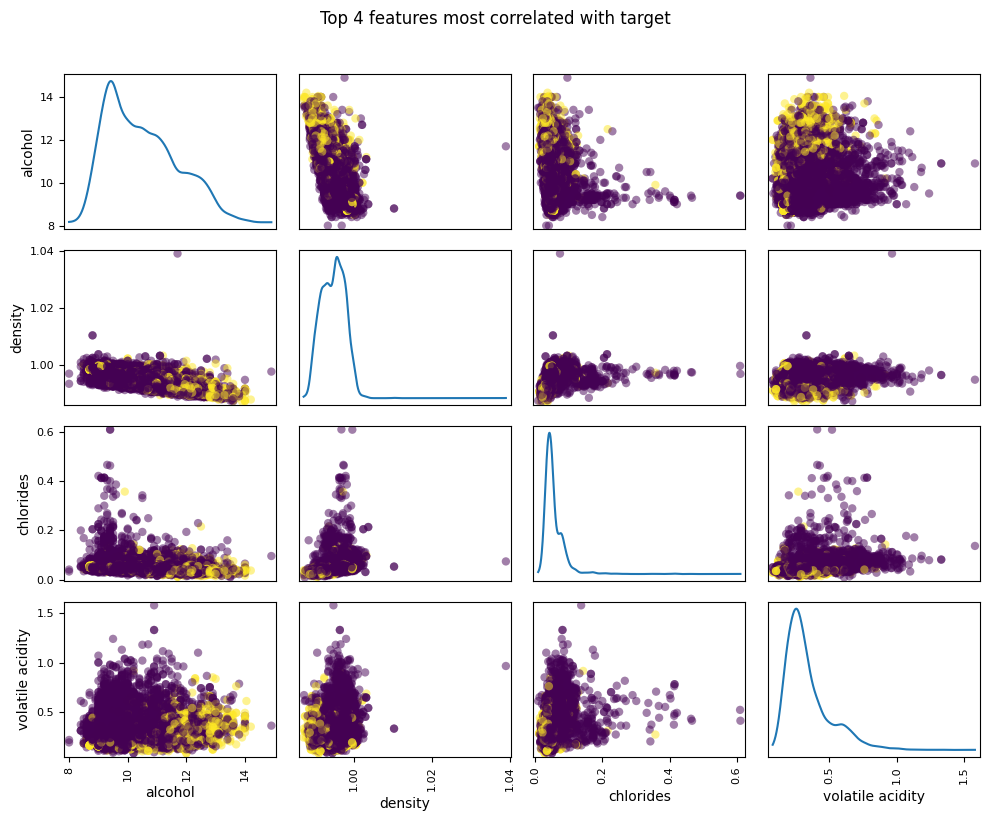

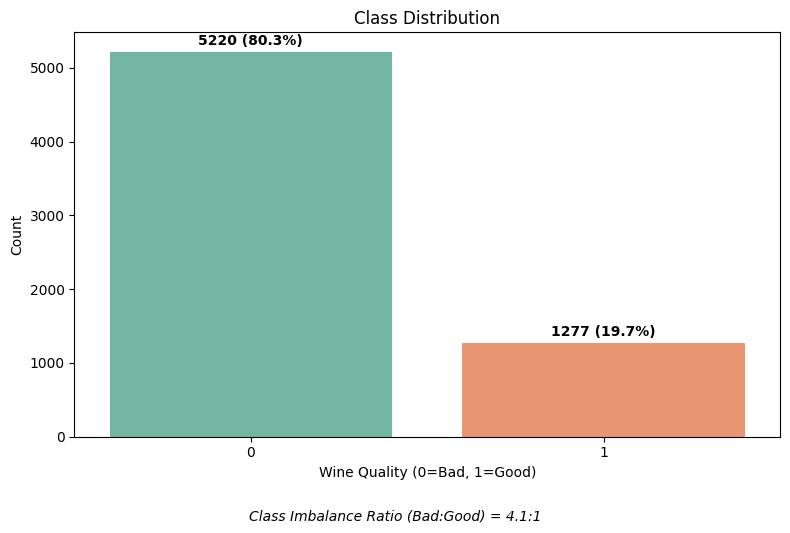


Part II: MLP & AdaBoost

Optimized MLP
--------------------------------------------------
Accuracy  : 0.8277
Precision : 0.5505
Recall    : 0.6684
F1 score  : 0.6038
AUC       : 0.8652
Optimal threshold : 0.3204
Train time: 5.0938s

              precision    recall  f1-score   support

         Bad     0.9145    0.8666    0.8899      1567
        Good     0.5505    0.6684    0.6038       383

    accuracy                         0.8277      1950
   macro avg     0.7325    0.7675    0.7468      1950
weighted avg     0.8430    0.8277    0.8337      1950



<Figure size 800x600 with 0 Axes>

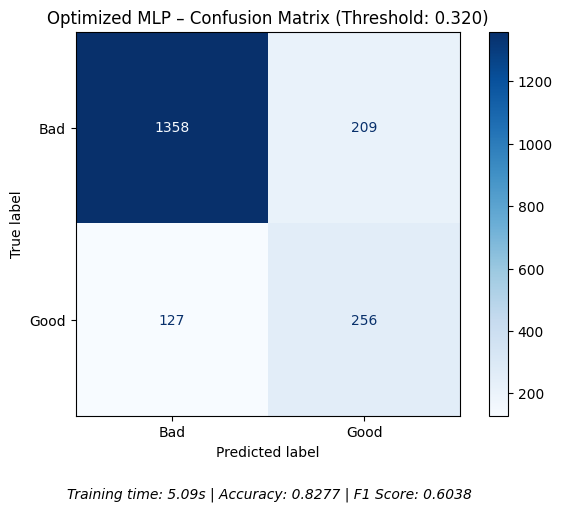

<Figure size 800x600 with 0 Axes>

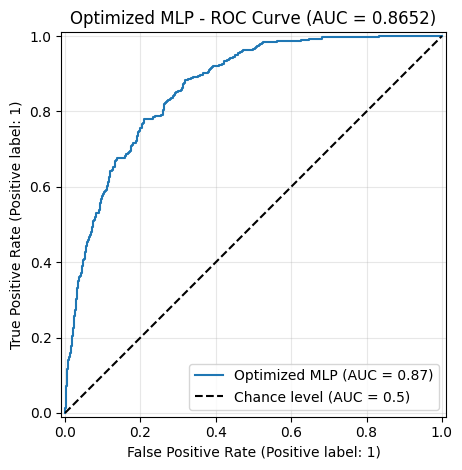

<Figure size 800x600 with 0 Axes>

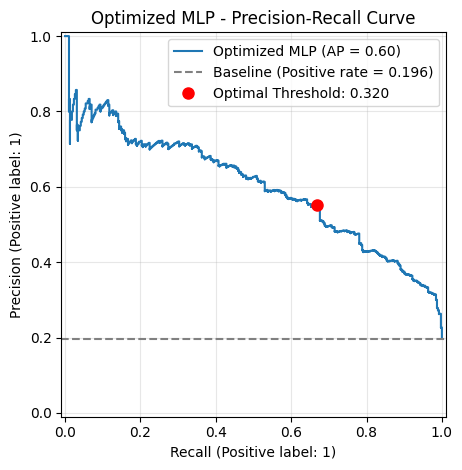


AdaBoost + MLP
--------------------------------------------------
Accuracy  : 0.8641
Precision : 0.6578
Recall    : 0.6423
F1 score  : 0.6499
AUC       : 0.8637
Optimal threshold : 0.4825
Train time: 48.5257s

              precision    recall  f1-score   support

         Bad     0.9131    0.9183    0.9157      1567
        Good     0.6578    0.6423    0.6499       383

    accuracy                         0.8641      1950
   macro avg     0.7854    0.7803    0.7828      1950
weighted avg     0.8629    0.8641    0.8635      1950



<Figure size 800x600 with 0 Axes>

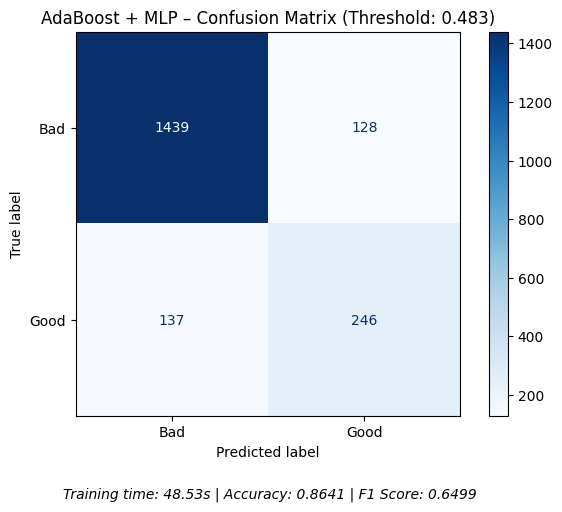

<Figure size 800x600 with 0 Axes>

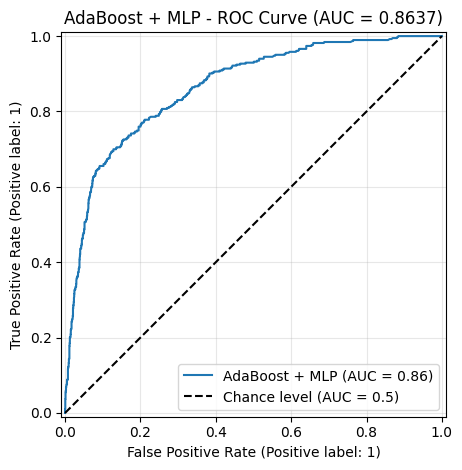

<Figure size 800x600 with 0 Axes>

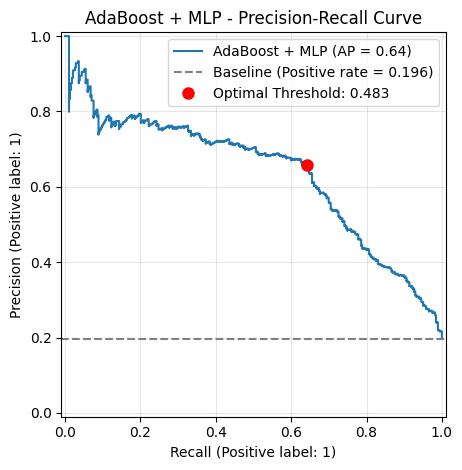


Part III: Perceptron Forest

Perceptron Forest
--------------------------------------------------
Accuracy  : 0.8359
Precision : 0.5602
Recall    : 0.7650
F1 score  : 0.6468
AUC       : 0.8794
Optimal threshold : 0.4520
Train time: 15.5106s

              precision    recall  f1-score   support

         Bad     0.9369    0.8532    0.8931      1567
        Good     0.5602    0.7650    0.6468       383

    accuracy                         0.8359      1950
   macro avg     0.7486    0.8091    0.7700      1950
weighted avg     0.8629    0.8359    0.8447      1950



<Figure size 800x600 with 0 Axes>

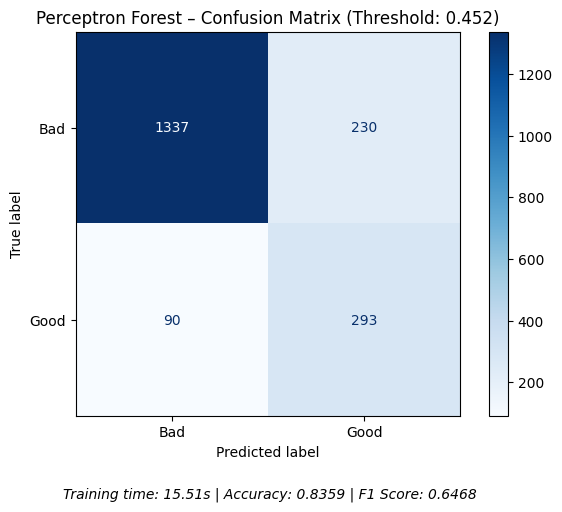

<Figure size 800x600 with 0 Axes>

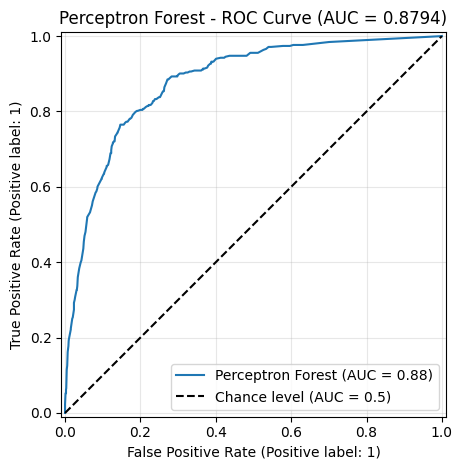

<Figure size 800x600 with 0 Axes>

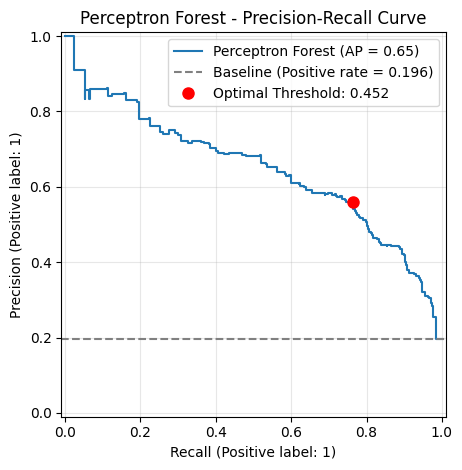


Final Model Comparison


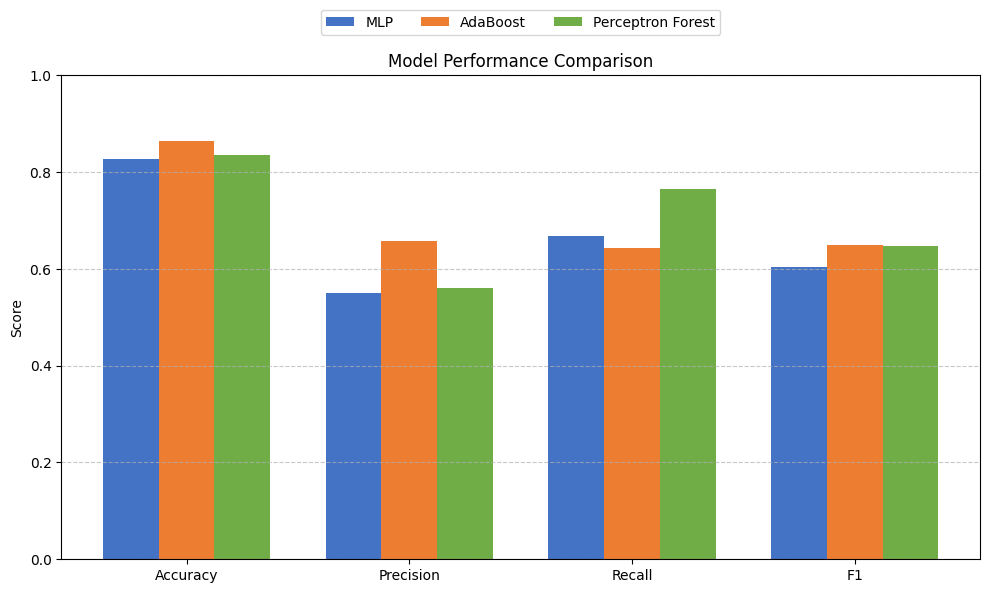

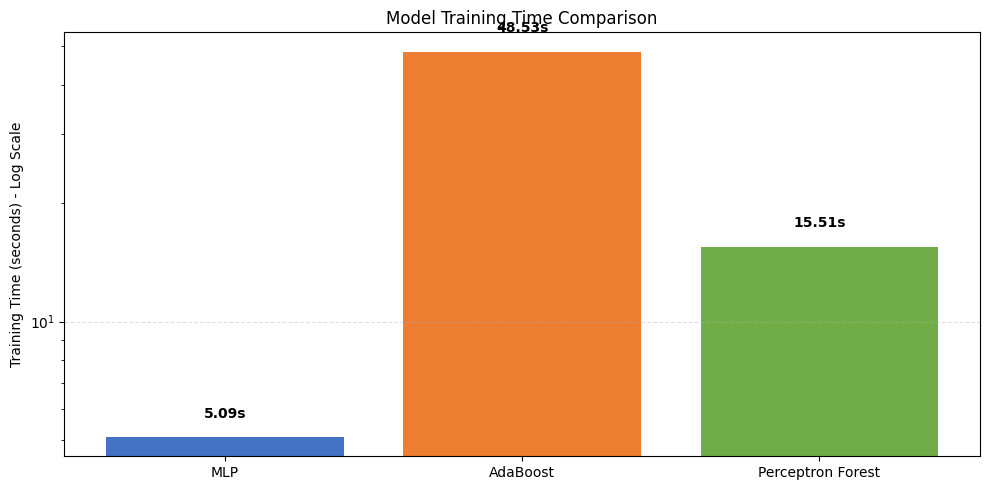


Model Performance Summary:
----------------------------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1         AUC        Threshold  Train Time      Speedup   
----------------------------------------------------------------------------------------------------
MLP                  0.8277     0.5505     0.6684     0.6038     0.8652     0.3204     5.0938         s 9.5x      
AdaBoost             0.8641     0.6578     0.6423     0.6499     0.8637     0.4825     48.5257        s 1.0x (baseline)
Perceptron Forest    0.8359     0.5602     0.7650     0.6468     0.8794     0.4520     15.5106        s 3.1x      

Best Models by Metric:
Best Accuracy : AdaBoost (0.8641)
Best Precision: AdaBoost (0.6578)
Best Recall   : Perceptron Forest (0.7650)
Best F1 Score : AdaBoost (0.6499)
Fastest Model : MLP (5.0938s)


In [57]:
def main():
    """Run the optimized analysis pipeline with pre-tuned parameters"""
    X_tr, X_te, y_tr, y_te, df, feats = load_and_prepare()

    # Enhanced EDA with top correlated features and class distribution
    quick_eda(df)

    # Part II: Optimized MLP
    print("\n" + "="*70)
    print("Part II: MLP & AdaBoost")
    print("="*70)

    # Use optimized parameters from previous tuning
    # Best MLP parameters: {'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant'}
    optimized_mlp = MLPClassifier(
        hidden_layer_sizes=(128,),
        alpha=0.001,
        learning_rate='constant',
        max_iter=300,
        random_state=RANDOM_STATE
    )

    r1 = evaluate_model(optimized_mlp, X_tr, X_te, y_tr, y_te, "Optimized MLP")

    # Optimized AdaBoost with fewer estimators and higher learning rate
    ada = AdaBoostClassifier(
        estimator=MLPForAdaBoost(**optimized_mlp.get_params()),
        n_estimators=15,  # Fewer estimators for faster training
        algorithm="SAMME",
        learning_rate=1.2,  # Higher learning rate for faster convergence
        random_state=RANDOM_STATE
    )
    r2 = evaluate_model(ada, X_tr, X_te, y_tr, y_te, "AdaBoost + MLP")

    # Part III: Optimized Perceptron Forest
    print("\n" + "="*70)
    print("Part III: Perceptron Forest")
    print("="*70)

    # Use optimized parameters from previous tuning
    # Best PerceptronForest parameters: {'n_estimators': 50, 'max_depth': 7, 'feat_frac': 0.9}
    optimized_pf = PerceptronForest(
        n_estimators=50,
        max_depth=7,
        feat_frac=0.9,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )

    r3 = evaluate_model(optimized_pf, X_tr, X_te, y_tr, y_te, "Perceptron Forest")

    # Final model comparison
    print("\n" + "="*70)
    print("Final Model Comparison")
    print("="*70)
    compare_metrics_and_time({
        "MLP": r1,
        "AdaBoost": r2,
        "Perceptron Forest": r3
    })

if __name__ == "__main__":
    main()

# Final Model Evaluation and Comparative Analysis


## **MLP(Multi-Layer Perceptron)**

The Multi-Layer Perceptron (MLP) used in this study consists of a single hidden layer. It learns non-linear decision boundaries by applying weights to input features, passing them through an activation function, and optimizing the network via backpropagation. Due to its relatively simple architecture, it serves as a strong baseline, particularly when the data is well-preprocessed (e.g., standardized via StandardScaler).

MLP achieved an accuracy of 82.77%, with a precision of 55.05% and recall of 66.84%, resulting in an F1 score of 60.38%. Its AUC value stood at 86.52%, indicating a solid capacity for distinguishing between positive and negative classes. With a training time of only 5.09 seconds, it was the fastest model. However, due to the class imbalance in the dataset (only 19.66% positives), MLP struggled with overpredicting the minority class, leading to suboptimal precision. The optimal threshold was automatically lowered to 0.32, favoring higher recall at the cost of precision.

While MLP offers rapid training and reasonable generalization, it does not incorporate mechanisms to adapt to misclassified examples or data imbalance. Its standalone nature limits its adaptability. Compared to ensemble methods, it lacks robustness, particularly when dealing with rare classes. It serves as a useful benchmark but is outperformed by ensemble approaches in nearly every metric except speed.

<br>
<br>

## **AdaBoost + MLP**

  AdaBoost is an ensemble learning method that trains multiple weak learners in sequence, each one focusing more on the mistakes of its predecessor. In this setup, each weak learner is a newly initialized MLP model. Sample weights are updated iteratively to emphasize misclassified examples, allowing the ensemble to incrementally reduce overall error. However, the training process is inherently serial, as each learner depends on the outcomes of the previous one.

  The AdaBoost + MLP ensemble delivered the highest accuracy at 86.41%, along with the best precision (65.78%) and best F1 score (64.99%). Recall was 64.23%, slightly below that of the Perceptron Forest. AUC stood at 86.37%, nearly identical to the baseline MLP. This suggests that while AdaBoost improved classification accuracy, it did not significantly improve class separability. The major downside is training time, which ballooned to 48.52 seconds, due to the serial training of multiple MLPs.

  AdaBoost significantly boosts the performance of MLP by iteratively correcting errors. However, it does so at the expense of training efficiency. Since it cannot parallelize training across iterations, it is computationally expensive. While it excels in producing balanced metrics (accuracy, precision, F1), its recall is slightly lower than the Perceptron Forest, which makes it less ideal in highly imbalanced classification tasks where false negatives must be minimized.

<br>
<br>

## **Perceptron Forest**

The Perceptron Forest is a custom ensemble model made up of decision trees where each node contains a trainable perceptron. These trees are constructed using random feature subsets and bootstrap samples. Decision boundaries are learned locally via linear classifiers, and each tree is trained independently. As a result, the model is inherently parallelizable, with each tree capable of being trained simultaneously.

The Perceptron Forest achieved an accuracy of 83.59%, with precision of 56.02% and the highest recall of 76.50% among all models. The F1 score was 64.68%, and the AUC was 87.94% — the best overall. Its training time was 15.51 seconds, notably faster than AdaBoost, and potentially even shorter if parallel execution is leveraged. Adaptive thresholding at leaf nodes enabled better handling of class imbalance, contributing to superior recall.

This model stands out in terms of class separability and minority class detection. Unlike AdaBoost, Perceptron Forest can be efficiently parallelized, resulting in significant time savings. While its precision is slightly lower than AdaBoost's, it achieves superior recall and AUC, making it ideal for applications where missing positive cases is costly (e.g., fraud detection, medical diagnosis). It offers the best trade-off between performance and computational efficiency.

<br>
<br>

## **Time Analysis**

AdaBoost is fundamentally serial: Each iteration relies on the outcome of the previous learner. This design inherently prevents parallelization, leading to long training times—especially when weak learners (like MLP) are computationally heavy. Perceptron Forest is fully parallelizable. Each tree is built independently using random samples and features, allowing for concurrent training on multi-core systems. This architectural choice significantly reduces overall training time without sacrificing accuracy. MLP, as a standalone model, is naturally fast but lacks the ensemble advantages of boosting or bagging.

<br>
<br>

## **Final Results**

* If maximum overall accuracy, precision, and F1 are the goals, and computation time is not a constraint, AdaBoost + MLP is the best choice.

* If recall and AUC are critical—particularly in situations where identifying positives is more important than avoiding false positives—Perceptron Forest is preferable.

* If time and simplicity are top priorities, and class imbalance is not extreme, MLP serves as a fast and easy-to-implement solution.
